<a href="https://colab.research.google.com/github/ibenatar-96/tiger-pomdp-mplr/blob/main/tiger_pomdp_mplr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install numpyro
!pip install funsor

In [2]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints
import matplotlib.pyplot as plt
import scipy.stats as stats
import funsor
import pandas as pd
import seaborn as sns
import jax
import jax.numpy as jnp
import sys
import os
import time
import copy
import random
import arviz as az
from itertools import product

numpyro.set_host_device_count(4)

# Tiger POMDP (Partially Observable Markov Decision Process)

The Tiger POMDP is a classical problem in the field of artificial intelligence and decision-making under uncertainty. It's used to illustrate the challenges of decision-making when there's uncertainty about the state of the environment.

In the Tiger POMDP scenario, an agent is placed in a room with two doors. Behind one door is his freedom, and behind the other is a tiger. The agent doesn't know which door leads to which outcome. It can take actions like "listen" to hear a sound indicating the location of the tiger or "open" a door to reveal its contents. However, actions are imperfect, leading to uncertainty.

Solving the Tiger POMDP involves finding a policy that maximizes the expected cumulative reward over time, taking into account the uncertainty and partial observability. Various algorithms, such as belief state planning or particle filtering, can be used to approximate or solve POMDPs.

The Tiger POMDP can be represented as a Partially Observable Markov Decision Process (POMDP) defined by the tuple $(S, A, T, R, Ω, O, γ)$, where:

\\
$S$: The finite set of states consists of two elements representing the locations of the tiger and his freedom.

$A$: The finite set of actions available to the agent includes "listen" and "open" representing actions to gather information or make decisions.

$T$: The state transition function $T: S \times A \mapsto S$ describes the transition probabilities between states based on actions. For example, if the agent decides to "open" a door, the state transition function will determine the probabilities of transitioning to either the tiger or freedom state.

$R$: The reward function $R: S \times A \mapsto \mathbb{R}$ provides immediate rewards for actions in specific states. For instance, opening the door containing his freedom could yield a positive reward, while opening the door with the tiger will result in a negative reward.

$Ω$: The finite set of observations consists of two elements representing the possible observations of "tiger-left" and "tiger-right" when the agent chooses to "listen".

$O$: The set of conditional observation probabilities $Ω$ specifies the likelihood of observing each possible observation given the true state of the environment.

$γ$: The discount factor $γ \in [0,1]$ accounts for the importance of future rewards relative to immediate rewards in the agent's decision-making process.

## Generating "Synthetic" Observations.

Now let's create synthetic observations / data for our model to learn from.

This synthetic data is following the rules of the original Tiger POMDP problem,
where the probability of getting a correct observation when doing "listen" action is 0.85.

Our observations will be in the form of a list that consists of episodes:

$b_{0},(a_{0},o_{0}),(a_{1},o_{1}),...,(,a_{n},o_{n})$

Where $(a_{t},o_{t})$ -

$a_{t}$ - the action taken in time step $t$

$o_{t}$ - the observation recieved at time step $t$

$\Omega = \{o_{tl}, o_{tr}\} $

Where $O(s',a,o) = P(o_{tl}|s',a_{listen}) = P(o_{tr}|s',a_{listen}) =
\begin{align}
     \left\{
        \begin{array}{cl}
        0.85 & \text{if s' == s}  \\
        0.15 & \text{if s' != s}
        \end{array}
    \right.
\end{align}$

\\

$O(s'_{tl},a_{listen},o_{tl}) = 0.85$

$O(s'_{tl},a_{listen},o_{tr}) = 0.15$

$O(s'_{tr},a_{listen},o_{tl}) = 0.15$

$O(s'_{tr},a_{listen},o_{tr}) = 0.85$


The context here of s' is that I have "reached" the state that the action took me to.
Meaning - for example, we know that $a_{listen}$ keeps us in the same state, so if the real tiger location is behind the left door - acting $a_{listen}$ will result in s' = "tiger-left", and the probability of observing $o_{tl}$ is 0.85, and the probability of observing $o_{tr}$ is 0.15.

* When action $a$ is "open-left" or "open-right", then recieving $o_{tl}$ and $o_{tr}$ are evenly distributed (uniformly).

Explanation - Observing the correct state occurs with probability 0.85, for example when the state is $s_{tl}$ (meaning the tiger is behind the left door), we will recieve the correct observation - $o_{tl}$ (that the tiger is behind the left door) with probability 0.85, and we will recieve the incorrect observation - $o_{tr}$ with probability 0.15.

In [3]:
Actions = ["listen", "open-left", "open-right"]
States = ["tiger-left", "tiger-right"]
Observations = ["tiger-left", "tiger-right"]
Inital_Belief_State = {"tiger-left": 0.5, "tiger-right": 0.5}
Terminate_Actions = ["open-left", "open-right"]

# Observation Model: {(state-prime, action): {observation1: probability1, observation2: probability2}}
Observation_Model = {("tiger-left","listen"): {"tiger-left": 0.85,
                                               "tiger-right": 0.15},
                     ("tiger-right","listen"): {"tiger-left": 0.15,
                                                "tiger-right":0.85},
                     ("tiger-left","open-left"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-right","open-left"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-left","open-right"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-right","open-right"): {"tiger-right":0.5,
                                                   "tiger-left":0.5}}

# Transition Model: {(state, action): {state-prime1: probability1, state-prime2: probability2}}
Transition_Model = {("tiger-left","listen"): {"tiger-left": 1.0,
                                               "tiger-right": 0.0},
                     ("tiger-right","listen"): {"tiger-left": 0.0,
                                                "tiger-right":1.0},
                     ("tiger-left","open-left"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-right","open-left"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-left","open-right"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-right","open-right"): {"tiger-right":0.5,
                                                   "tiger-left":0.5}}

In [4]:
def gen_obs(num_samples=15):
    episodes_obs = []
    for _ in range(num_samples): # create num_samples episodes
        episode_log = []
        tiger_state = np.random.choice(States, size=None)
        listen_probs = [0.85, 0.15] if tiger_state == 'tiger-left' else [0.15, .85]
        listen_obs = np.random.choice(Observations, size=None, p=listen_probs)
        open_obs = np.random.choice(Observations, size=None, p=[1 if state == tiger_state else 0 for state in States])
        episodes_obs.append([("listen", listen_obs), (listen_obs.replace("tiger", "open"), open_obs)])
    return episodes_obs

In [5]:
num_samples=20
observations = gen_obs(num_samples=num_samples)
for i in range(min(num_samples, 5)):
    print(f"obs[{i}] = {observations[i]}")
print(sum(1 for obs in observations if obs[0][1] == obs[1][1])/num_samples)

obs[0] = [('listen', 'tiger-right'), ('open-right', 'tiger-right')]
obs[1] = [('listen', 'tiger-right'), ('open-right', 'tiger-right')]
obs[2] = [('listen', 'tiger-left'), ('open-left', 'tiger-left')]
obs[3] = [('listen', 'tiger-left'), ('open-left', 'tiger-left')]
obs[4] = [('listen', 'tiger-left'), ('open-left', 'tiger-right')]
0.85


In [6]:
data = []
for episode in observations:
    row = {}
    row['action1'], row['obs1'] = episode[0]
    row['action2'], row['obs2'] = episode[1]
    data.append(row)

data = pd.DataFrame(data, columns=['action1', 'obs1', 'action2', 'obs2'])
data.head()

,action1,obs1,action2,obs2
0,listen,tiger-right,open-right,tiger-right
1,listen,tiger-right,open-right,tiger-right
2,listen,tiger-left,open-left,tiger-left
3,listen,tiger-left,open-left,tiger-left
4,listen,tiger-left,open-left,tiger-right


In [22]:
# Now lets preprocess the data and turn it into numeric values, so we can work with numpyro.

actions = ["listen", "open-left", "open-right"] # listen = 0, open-left = 1, open-right = 2
observations = ["tiger-left", "tiger-right"] # tiger-left = 0, tiger-right = 1

def preprocess_data(df):
    action_map = {action: i for i, action in enumerate(actions)}
    obs_map = {obs: i for i, obs in enumerate(observations)}
    df_numeric = df.copy()
    df_numeric['action1'] = df['action1'].map(action_map)
    df_numeric['action2'] = df['action2'].map(action_map)
    df_numeric['obs1'] = df['obs1'].map(obs_map)
    df_numeric['obs2'] = df['obs2'].map(obs_map)
    return df_numeric

data = preprocess_data(data)
data.head()

,action1,obs1,action2,obs2
0,0,1,2,1
1,0,1,2,1
2,0,0,1,0
3,0,0,1,0
4,0,0,1,1


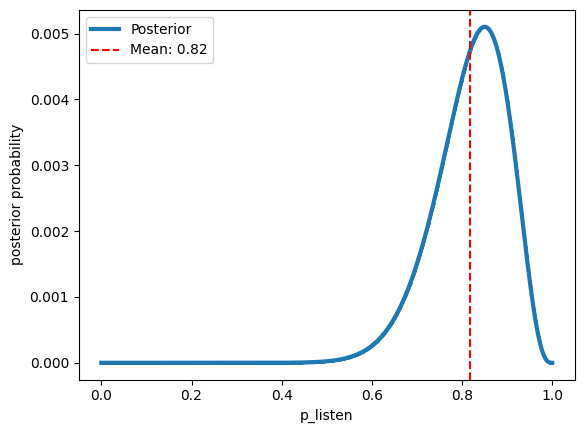

In [17]:
num=1000
p_grid = jnp.linspace(start=0, stop=1, num=num)
prior = jnp.repeat(1, num)
listen_attempts = data.stack().value_counts()["listen"]
listen_success = data.apply(lambda row: row['action1'] == 'listen' and row['obs1'] == row['obs2'], axis=1).sum()
likelihood = jnp.exp(dist.Binomial(total_count=listen_attempts, probs=p_grid).log_prob(listen_success))
unstd_posterior = likelihood * prior
std_posterior = unstd_posterior / jnp.sum(unstd_posterior)

mean_posterior = jnp.sum(p_grid * std_posterior)
plt.plot(p_grid, std_posterior, '-o', linewidth=3, markersize=1, label='Posterior')
plt.axvline(mean_posterior, color='red', linestyle='--', label=f'Mean: {mean_posterior:.2f}')
plt.xlabel("p_listen")
plt.ylabel("posterior probability")
plt.legend()
plt.show()


# Model

## POMDP definition

 0 - left, 1 - right

 $States$ = {0, 1}

 $\Omega$ = {0, 1}

$Actions$ = {Listen, Open}

 $Observations$ =
* State = 0, A=Listen => p_l, 1-p_l -- If we choose to Listen and the State is 0, we will recieve observation 0 (Left) with probability p_l and 1 (Right) with prob. 1-p_l
* State=1, A=Listen => 1-p_l, p_l -- If we choose to Listen and the State is 1, we will recieve observation 0 (Left) with probability 1-p_l and 1 (Right) with prob. p_l
* State=0, A=Open => 1, 0 -- If we choose to Open and the State is 0, we will always recieve observation 0 (Left) [probability is 1].
* S=1, A=O, => 0, 1 -- If we choose to Open and the State is 1, we will always recieve observation 1 (Right) [probability is 1].


## Parameter learning

$\epsilon = 0.01$ // Approximate Bayesian computation

$p_0 \sim Beta(1, 1)$ Sampling probability for initial state\
$p_l \sim Beta(1, 1)$ Sampling probability for listen observations

$s \sim Bernoulli(p_0)$ Sampling Initial state (s0)


for a, o in history:
* if a==listen:
    * if s==0: (if state is 'tiger-left')
        * $o \sim Bernoulli(1-p_l)$
    * elsif s==1 (if state is 'tiger-right'):
        * $o \sim Bernoulli(p_l)$
* elsif a==open:
    * if s==0:
        * $o \sim Bernoulli(\epsilon)$
    * elsif s==1:
        * $o \sim Bernoulli(1-\epsilon)$

In [79]:
def model1(data):
    epsilon = numpyro.deterministic("epsilon", 0.01)
    p_listen = numpyro.sample("p_listen", dist.Beta(1,1))
    # p_0 = numpyro.deterministic("p_0", 0.5)
    p_0 = numpyro.sample("p_0", dist.Beta(1,1))
    n_episodes = data.shape[0]
    actions = data[['action1', 'action2']].values
    observations = data[['obs1', 'obs2']].values
    for episode in range(n_episodes):
        s = numpyro.sample(f"s_{episode}", dist.Categorical(probs=jnp.array([p_0, 1-p_0])), infer={'enumerate': 'parallel'})
        a = actions[episode, :]
        o = observations[episode, :]
        for i, action in enumerate(a):
            if action == 0:
                p = jnp.where(s == 1, p_listen, 1 - p_listen)
                numpyro.sample(f"obs_{episode}_{i}", dist.Bernoulli(p), obs=o[0])
            else:
                p = jnp.where(s == 1, 1 - epsilon, epsilon)
                numpyro.sample(f"obs_{episode}_{i}", dist.Bernoulli(p), obs=o[1])

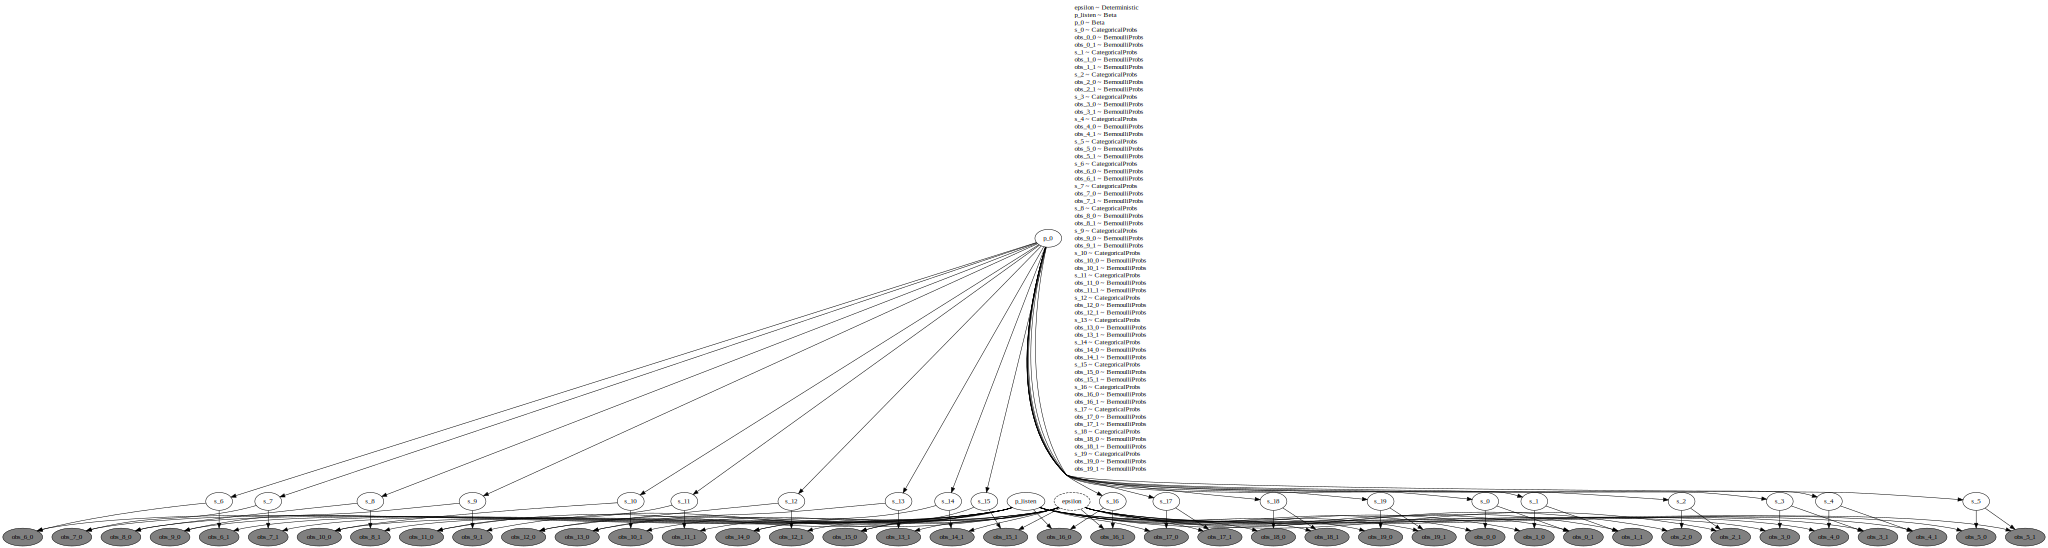

In [80]:
numpyro.render_model(model1, model_args=(data,), render_distributions=True, render_params=True,)

In [105]:
def model2(data):
    epsilon = numpyro.deterministic("epsilon", 0.01)
    p_listen = numpyro.sample("p_listen", dist.Beta(1,1))
    p_0 = numpyro.sample("p_0", dist.Beta(1,1))
    n_episodes = data.shape[0]
    actions = data[['action1', 'action2']].values
    n_actions = actions.shape[1]
    observations = data[['obs1', 'obs2']].values
    with numpyro.plate("episodes", n_episodes, dim=-1):
        s = numpyro.sample("s", dist.Categorical(probs=jnp.array([p_0, 1 - p_0])), infer={'enumerate': 'parallel'})

        for i in range(n_actions):
            a = actions[:, i]
            o = observations[:, i]

            p_listen_cond = jnp.where(s == 1, p_listen, 1 - p_listen)
            p_action_cond = jnp.where(s == 1, 1 - epsilon, epsilon)

            p = jnp.where(a == 0, p_listen_cond, p_action_cond)
            numpyro.sample(f"obs_{i}", dist.Bernoulli(p), obs=o)

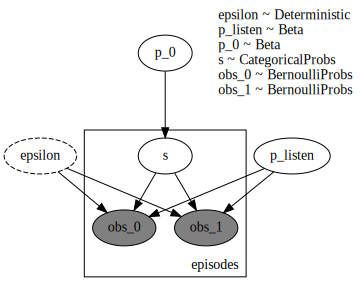

In [101]:
numpyro.render_model(model2, model_args=(data,), render_distributions=True, render_params=True,)

In [45]:
def inference(ai_model, data):
    nuts_kernel = numpyro.infer.NUTS(ai_model)
    mcmc = numpyro.infer.MCMC(
        nuts_kernel,
        num_warmup=500,
        num_chains=4,
        num_samples=5000)
    mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), data=data)
    mcmc.print_summary()
    return mcmc

In [81]:
mcmc_1 = inference(model1, data)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       p_0      0.40      0.10      0.40      0.23      0.57  16336.47      1.00
  p_listen      0.83      0.08      0.84      0.71      0.96  17132.50      1.00

Number of divergences: 0


In [102]:
mcmc_2 = inference(model2, data)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       p_0      0.40      0.10      0.40      0.23      0.57  14263.50      1.00
  p_listen      0.83      0.08      0.84      0.71      0.96  16522.71      1.00

Number of divergences: 0


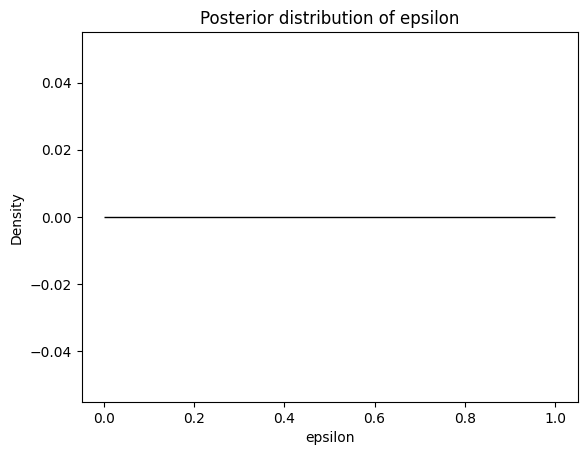

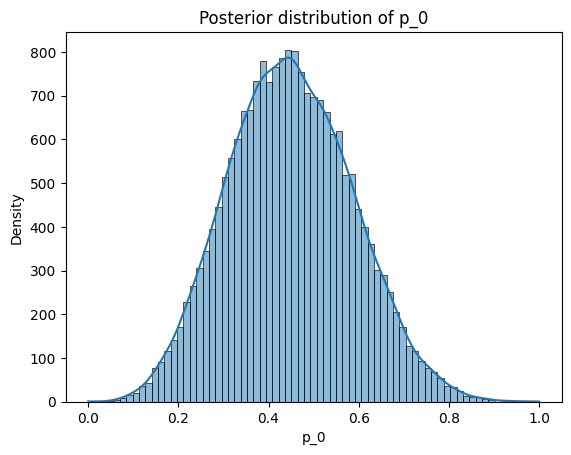

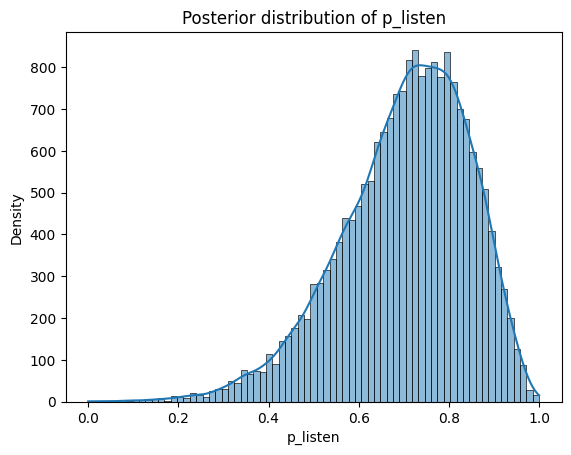

In [104]:
# Plotting the samples
def plot_samples(name, samples):
    normalize = lambda x: (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))
    samples = normalize(samples)
    sns.histplot(samples, kde=True)
    plt.xlabel(param_name)
    plt.ylabel('Density')
    plt.title(f'Posterior distribution of {name}')
    plt.show()

# Assuming your model has parameters 'param1', 'param2', etc.
samples = mcmc_2.get_samples()
for param_name, param_samples in samples.items():
    plot_samples(param_name, param_samples)